In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Read and Vectorise Documents

Simple Wiki's abstracts

In [10]:
all_docs = !xmllint --shell ../data/simplewiki-latest-abstract.xml.gz <<< "cat //doc/abstract"

In [11]:
all_docs[:10]

['/ >  -------',
 '<abstract>April is the 4th month of the year, and comes between March and May. It is one of four months to have 30 days.</abstract>',
 ' -------',
 '<abstract>August (Aug.) is the 8th month of the year in the Gregorian calendar, coming between July and September.</abstract>',
 ' -------',
 '<abstract>Art is a creative activity by people.  These people are called artists.</abstract>',
 ' -------',
 '<abstract>A is the first letter of the English alphabet. The small letter, a, is used as a lower case vowel.</abstract>',
 ' -------',
 '<abstract>thumb|240px|This is what the air is made of</abstract>']

In [12]:
all_docs = all_docs[1::2]
len(all_docs)

130870

In [13]:
docs = [s for s in all_docs
        if 'United States' in s]
len(docs)

6130

TF-IDF Vectoriser

In [14]:
n_features = 20000

In [15]:
tfidf_vectorizer = TfidfVectorizer(max_df=.95, min_df=1,
                                   max_features=n_features,
                                   lowercase=False,
                                   stop_words='english')
tfidf_vectorizer.fit(all_docs)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.95, max_features=20000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [16]:
tfidf = tfidf_vectorizer.transform(docs)
tfidf.shape

(6130, 20000)

TF Vectoriser

In [17]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=1,
                                max_features=n_features,
                                lowercase=False,
                                stop_words='english',
                                vocabulary=tfidf_vectorizer.vocabulary_)
tf_vectorizer.fit(all_docs)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.95, max_features=20000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None,
        vocabulary={'April': 1545, '4th': 919, 'month': 16237, 'year': 19948, 'comes': 12685, 'March': 6900, 'May': 7036, 'It': 5717, 'months': 16239, '30': 746, 'days': 13200, 'August': 1715, '8th': 1086, 'Gregorian': 4915, 'calendar': 12207, 'coming': 12691, 'July': 5939, 'September': 9358, 'Art': 1629, '...usa': 1860, 'Arthrostylidium': 1631, 'Losser': 6607, 'Zorlu': 11154, 'Takam': 10011, 'Parvat': 8179})

In [18]:
tf = tf_vectorizer.transform(docs)
tf.shape

(6130, 20000)

# Topic Modelling

In [19]:
def print_top_words_factors(factors, feature_names, n_top_words):
    ''' Print top words of each topic '''
    for topic_idx, topic in enumerate(factors):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

def print_top_words(model, feature_names, n_top_words):
    ''' Print top words of each topic '''
    print_top_words_factors(model.components_, feature_names, n_top_words)

## NMF

In [20]:
nmf = NMF(n_components=10, init='random', alpha=.3, l1_ratio=1e-6)
nmf.fit(.8 * tfidf + .2 * tf)
print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: city States United Illinois Idaho Florida Oklahoma Indiana Chicago City Beach Park Lake St Springs Heights seat Mount Ohio Miami
Topic #1: The States United President population War census National presidential It Reagan 2010 Congress Department government American held second started State
Topic #2: Iowa city States United City 2000 Rock Lake Grove St population people Junction Center Mount Indiana Rapids Sioux Oklahoma Falls
Topic #3: state Arkansas America city States United Indiana City Springs North living Sebastian Delaware people largest County located states West Bluff
Topic #4: County county census population seat 2010 It city States United 2000 Alabama people Ohio At Oklahoma As lived town community
Topic #5: United States It American He Constitution government Army born Florida Canada people country Louisiana Court In Navy Kingdom Washington Department
Topic #6: New York City States United birth_place Jersey Brooklyn Dutchess community Manhattan skyscraper Bronx me

In [21]:
nmf = NMF(n_components=10, init='random', alpha=.3, l1_ratio=1e-6)
nmf.fit(.2 * tfidf + .8 * tf)
print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: United States It American He born Constitution government President Army Canada people 2016 known March January called used June December
Topic #1: County county census population 2010 It seat 2000 people Alabama city At As Ohio lived States United town community unincorporated
Topic #2: city States United Kentucky Florida Idaho Oklahoma Indiana City Beach Ohio seat As Kenton Hills Lake Park Alabama Springs St
Topic #3: Virginia town States United West unincorporated community Connecticut South About Mount small 2000 Blue Maine Louisiana Parish Hampton Ridge people
Topic #4: New York City Jersey States United Dutchess community Brooklyn Manhattan skyscraper feet meters tall floors Haven It As Island Times
Topic #5: Iowa city States United people City 2000 Rock population In lived Lake St Junction Grove Mount Center living 2010 Census
Topic #6: state America Arkansas States United city Indiana North people living states In Delaware county largest Sebastian governments Wisconsi

In [22]:
nmf = NMF(n_components=10, init='random', alpha=.3, l1_ratio=1e-6)
nmf.fit(tf)
print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: United States President government Constitution people In Department This Army Court Congress Kingdom called Canada They Census federal Amendment Louisiana
Topic #1: County census population 2010 county 2000 seat people States United Alabama city As At lived town Ohio community unincorporated designated
Topic #2: Virginia town States United West Connecticut Blue Mount South About Hampton Carolina small Maine Ridge unincorporated eastern McClure Norfolk area
Topic #3: It United States seat county County Oklahoma largest feet started Chicago skyscraper tall floors meters released River Florida season second
Topic #4: New York City States United Jersey birth_place Dutchess community Manhattan Brooklyn feet skyscraper Haven meters tall floors Times Island As
Topic #5: The States United President War National Department government Canada Congress Reagan held presidential State population second used started census North
Topic #6: city States United Iowa Kentucky Illinois Florida I

## Latent Dirichlet Allocation

Variational Inference for LDA

In [23]:
lda = LatentDirichletAllocation(n_components=10,
                                doc_topic_prior=1,
                                topic_word_prior=1,
                                max_iter=10,
                                learning_method='online',
                                learning_offset=100)
lda.fit(tf)
print_top_words(lda, tf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: music chart blues rock Billboard hop 1960s hip songs Songs Hot rhythm singles single airplay punk type Country access singers
Topic #1: States United Idaho birth_place origin Iowa chicken Illinois Kentucky cake Montana Origin restaurant Indiana Social Virginia Airlines locations death_place cultural_origins
Topic #2: chicken missiles United States strips seeking air birth_place Idaho ground Chicken destroy anti aircraft surface guns baked supposed origin enemy
Topic #3: States United Idaho birth_place Illinois origin Iowa Indiana chicken restaurant cake Origin Kentucky Montana city Social Virginia Airlines locations death_place
Topic #4: United States birth_place Idaho origin Iowa Illinois Origin chicken Kentucky restaurant cake Montana Indiana Social city Virginia Airlines locations death_place
Topic #5: States birth_place United Idaho origin Iowa Illinois city Indiana chicken restaurant Kentucky Origin cake Montana Social Virginia Airlines locations country
Topic #6: birth_

In [25]:
lda = LatentDirichletAllocation(n_components=10,
                                doc_topic_prior=.5,
                                topic_word_prior=1,
                                max_iter=10,
                                learning_method='online',
                                learning_offset=100)
lda.fit(tf)
print_top_words(lda, tf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: fossil Certification Format Chronology Length Brain Nothing Genre Digital Writer Rihanna Producer download Next Label Is Platinum Recording Last singles
Topic #1: County population census county seat 2000 Alabama 2010 At designated As Statistical CDP Area township Montgomery Birmingham city Metropolitan included
Topic #2: Chattanooga index org Set upright cat comparison tails Index Death birth_place https Fayetteville spider region1 Social origin Fayette Glasgow alcohol
Topic #3: Microsoft access alloy Windows YouTube videos advertising internet operating Google offered Verizon computers mobile Country paid background devices subscription users
Topic #4: milk cream removed semi resulting Sometimes instead half Chattanooga index org Set upright cat tails comparison Index Death Fayetteville spider
Topic #5: United States city The It birth_place Iowa County New state American Illinois Kentucky York Virginia town people America President City
Topic #6: cookie portions baked chip 

In [27]:
lda = LatentDirichletAllocation(n_components=10,
                                doc_topic_prior=.2,
                                topic_word_prior=1,
                                max_iter=10,
                                learning_method='online')
lda.fit(tf)
print_top_words(lda, tf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: access YouTube videos internet advertising Verizon offered temperature increases treatment schizophrenia Ultimate height Nielsen Communications fossil resources background playback devices
Topic #1: licenses Creative Commons performing bite painful capable snakes highly relates copyright vipers Water venomous nonprofit corporation species 2002 southern released
Topic #2: Present region1 Chattanooga Florida 339 Tampa origin Fayetteville birth_place Fayette Glasgow Toronto Ada Montreal Ottawa Idaho nationality Oklahoma Kirkland Custer
Topic #3: York New seat county Florida Louisiana Parish City community hurricane Hurricane unincorporated Brooklyn Dutchess Jersey parish Atlantic storm Beach Haven
Topic #4: Present region1 Chattanooga Florida 339 Tampa origin Fayetteville birth_place Fayette Glasgow Toronto Ada Montreal Ottawa Idaho nationality Oklahoma Kirkland Custer
Topic #5: United States city The It County birth_place Iowa state American Illinois Kentucky Virginia town 2010

## Spectral LDA

In [28]:
import sys
sys.path.insert(0, '../SpectralLDA')

from spectral_lda import spectral_lda

Using mxnet backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using numpy backend.


In [29]:
alpha, beta = spectral_lda(tf, alpha0=10, k=10)
print_top_words_factors(beta.T, tf_vectorizer.get_feature_names(), 20)

# docs: 6130	# valid: 6106


Topic #0: States United city Iowa York City Kentucky Idaho Brooklyn Jersey Chicago Mount Park Hills St Grove Lake Rock Heights Oakland
Topic #1: States York The City American He born Brooklyn people Jersey President War January February It March Manhattan University September known
Topic #2: United York The American City He It people born President War January Brooklyn February March Jersey University known September April
Topic #3: city birth_place The It Iowa Virginia state County America town country Kentucky American President Idaho Canada people government Army thumb
Topic #4: city The California It Arkansas America Texas Massachusetts country Virginia American President county Pennsylvania census Canada Ohio Louisiana Alabama Michigan
Topic #5: city States United state Arkansas America Indiana City Springs Rock Sebastian Clarksville Jonesboro Monticello Camden living Delaware London Decatur West
Topic #6: States United York New City birth_place Jersey Brooklyn California Chicago 

In [30]:
alpha, beta = spectral_lda(tf, alpha0=5, k=10)
print_top_words_factors(beta.T, tf_vectorizer.get_feature_names(), 20)

# docs: 6130	# valid: 6106


Topic #0: States United city Iowa York Kentucky City Idaho Illinois Chicago Brooklyn Jersey Florida Park Mount Hills St Lake Grove Rock
Topic #1: States York The American He people born War January February City University March As September Manhattan Brooklyn April known July
Topic #2: United York The American people He born War January University As February March City 2010 President living Manhattan April July
Topic #3: city birth_place The It Iowa state Virginia County America country American town Kentucky President Canada Idaho people government In Army
Topic #4: city The It America Arkansas California country American Virginia President county Massachusetts Texas census Canada people government counties In state
Topic #5: States city United state Arkansas America Indiana City Springs Rock Sebastian Clarksville Monticello Jonesboro Delaware West living Camden London Decatur
Topic #6: States United York New City birth_place Jersey Brooklyn California Chicago Angeles Los Texas Illi

In [31]:
alpha, beta = spectral_lda(tf, alpha0=2, k=10)
print_top_words_factors(beta.T, tf_vectorizer.get_feature_names(), 20)

# docs: 6130	# valid: 6106


Topic #0: city Iowa Illinois Kentucky California The Florida Texas Massachusetts Oklahoma country Ohio Idaho It Pennsylvania Alabama American Michigan Indiana President
Topic #1: United States city County county seat It population census 2010 2000 Oklahoma The New people York Alabama community Kentucky Florida
Topic #2: United York New City Jersey Brooklyn county population census 2010 Dutchess seat Manhattan Bronx As 2000 Queens community people San
Topic #3: city birth_place The town America Virginia New Arkansas York Chicago county It community unincorporated In counties Massachusetts American President people
Topic #4: city Iowa birth_place Kentucky Idaho The Florida It country Illinois Oklahoma American state President Canada thumb Army Navy government He
Topic #5: city States United state Arkansas America Indiana City Springs York Rock living Delaware Sebastian Clarksville West Camden Jonesboro Decatur Monticello
Topic #6: States United York New birth_place City Jersey Brooklyn C

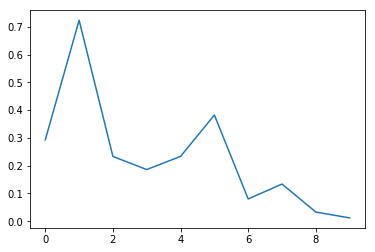

In [33]:
plt.plot(alpha)